In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pycocotools

Mounted at /content/drive


In [2]:
!pip install -U albumentations

IMPORT AND CONFIGURATION

In [3]:
import json
import os

print("--- Starting COCO JSON Merge Script ---")

# --- 1. Define File Paths ---
# Define the main project folder first to resolve the error
PROJECT_FOLDER_IN_DRIVE = '/content/drive/MyDrive/oct_major_project/'

NORMAL_JSON_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'NORMAL 2.v1i.coco-segmentation/train/_annotations.coco.json')
DRUSEN_JSON_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'drusen 2.v1i.coco-segmentation/train/_annotations.coco.json')
COMBINED_DATA_DIR = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'combined_data/')
OUTPUT_JSON_PATH = os.path.join(COMBINED_DATA_DIR, '_merged_annotations.coco.json')

# --- 2. Load JSON Data from Files ---
print(f"Loading NORMAL annotations...")
with open(NORMAL_JSON_PATH, 'r') as f:
    normal_data = json.load(f)

print(f"Loading DRUSEN annotations...")
with open(DRUSEN_JSON_PATH, 'r') as f:
    drusen_data = json.load(f)

# --- 3. Prepare the Merged Data Structure ---
merged_data = {
    "info": drusen_data['info'], "licenses": drusen_data['licenses'], "categories": [],
    "images": [], "annotations": []
}
merged_data['info']['description'] = "Merged NORMAL and DRUSEN datasets."
category_map = {}
for cat in drusen_data['categories'] + normal_data['categories']:
    cat_id = cat['id']
    if cat_id not in category_map:
        category_map[cat_id] = cat
merged_data['categories'] = list(category_map.values())

# --- 4. Define and Use the Helper Function ---
def process_dataset(source_data, image_id_offset, ann_id_offset):
    images = []
    annotations = []
    image_id_map = {}
    for img in source_data['images']:
        old_id = img['id']
        new_id = old_id + image_id_offset
        image_id_map[old_id] = new_id
        img['id'] = new_id
        images.append(img)
    for ann in source_data['annotations']:
        ann['id'] += ann_id_offset
        ann['image_id'] = image_id_map[ann['image_id']]
        annotations.append(ann)
    return images, annotations

normal_images, normal_annotations = process_dataset(normal_data, 0, 0)
merged_data['images'].extend(normal_images)
merged_data['annotations'].extend(normal_annotations)

image_id_offset = len(merged_data['images'])
ann_id_offset = len(merged_data['annotations'])

drusen_images, drusen_annotations = process_dataset(drusen_data, image_id_offset, ann_id_offset)
merged_data['images'].extend(drusen_images)
merged_data['annotations'].extend(drusen_annotations)

# --- 5. Save the Merged File ---
print(f"\nSaving merged annotations to: {OUTPUT_JSON_PATH}")
os.makedirs(COMBINED_DATA_DIR, exist_ok=True)
with open(OUTPUT_JSON_PATH, 'w') as f:
    json.dump(merged_data, f, indent=4)

print("\n--- Merge Complete! ---")

--- Starting COCO JSON Merge Script ---
Loading NORMAL annotations...
Loading DRUSEN annotations...

Saving merged annotations to: /content/drive/MyDrive/oct_major_project/combined_data/_merged_annotations.coco.json

--- Merge Complete! ---


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import os
import cv2
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
import json
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2

# This is already mounted, but it doesn't hurt to have it here.
# from google.colab import drive
# drive.mount('/content/drive')

# --- Path Definitions for the ML part ---
PROJECT_FOLDER_IN_DRIVE = '/content/drive/MyDrive/oct_major_project/'
COMBINED_DATA_DIR = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'combined_data/')
JSON_PATH = os.path.join(COMBINED_DATA_DIR, '_merged_annotations.coco.json')
IMAGE_DIR = os.path.join(COMBINED_DATA_DIR, 'images/')
MASK_SAVE_DIR = os.path.join(COMBINED_DATA_DIR, 'masks/')

os.makedirs(MASK_SAVE_DIR, exist_ok=True)

# --- Hyperparameters ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
BATCH_SIZE = 4
NUM_CLASSES = 11
K_FOLDS = 5
NUM_EPOCHS_PER_FOLD = 25

print(f"ML Setup Complete. Using device: {DEVICE}")

ML Setup Complete. Using device: cuda


GROUND TRUTH MASK GENERATION

In [5]:
print("Loading COCO JSON for segmentation...")
# This assumes JSON_PATH and MASK_SAVE_DIR have been defined.
coco = COCO(JSON_PATH)
img_ids = coco.getImgIds()
images = coco.loadImgs(img_ids)

print(f"Found {len(images)} images. Starting mask generation...")

for img_info in tqdm(images, desc="Generating Masks"):
    img_id = img_info['id']
    img_file_name = img_info['file_name']
    img_height = img_info['height']
    img_width = img_info['width']

    mask = np.zeros((img_height, img_width), dtype=np.uint8)
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        category_id = ann['category_id']
        for seg in ann['segmentation']:
            poly = np.array(seg, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [poly], color=(category_id))

    base_name = img_file_name.split('.')[0]
    mask_file_name = f"{base_name}.png"
    save_path = os.path.join(MASK_SAVE_DIR, mask_file_name)
    cv2.imwrite(save_path, mask)

print(f"\nMask generation complete! The images are saved in: {MASK_SAVE_DIR}")

Loading COCO JSON for segmentation...
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Found 39 images. Starting mask generation...


Generating Masks: 100%|██████████| 39/39 [00:12<00:00,  3.20it/s]


Mask generation complete! The images are saved in: /content/drive/MyDrive/oct_major_project/combined_data/masks/


UNET MODEL DEFENITION

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=NUM_CLASSES, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

print("U-Net model class defined.")

U-Net model class defined.


CUSTOM DATASET CLASS

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_file = self.images[index]
        mask_file = img_file.split('.')[0] + '.png'

        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.medianBlur(image, 5)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask


train_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussianBlur(p=0.2),
        A.GaussNoise(p=0.2),


        A.Normalize(mean=[0.5], std=[0.5]),


        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=512, width=512),


        A.Normalize(mean=[0.5], std=[0.5]),


        ToTensorV2(),
    ]
)

print("Dataset class and augmentation transforms have been updated.")

Dataset class and augmentation transforms have been updated.


In [8]:
# Block 8: Helper Functions for Training and Evaluation

def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader, desc="Training")
    model.train()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device=DEVICE), targets.to(device=DEVICE)
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

def check_metrics(loader, model, device="cuda"):
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.argmax(model(x), dim=1)

            # Convert to one-hot for multi-class metric calculation
            y_one_hot = torch.nn.functional.one_hot(y, num_classes=NUM_CLASSES).permute(0, 3, 1, 2)
            preds_one_hot = torch.nn.functional.one_hot(preds, num_classes=NUM_CLASSES).permute(0, 3, 1, 2)

            intersection = (preds_one_hot * y_one_hot).sum()
            union = preds_one_hot.sum() + y_one_hot.sum()

            dice_score += (2. * intersection) / (union + 1e-8)
            iou_score += intersection / (union - intersection + 1e-8)

    avg_dice = dice_score / len(loader)
    avg_iou = iou_score / len(loader)

    print(f"Validation Dice Score: {avg_dice:.4f}")
    print(f"Validation IoU Score: {avg_iou:.4f}")

    model.train()
    return avg_dice, avg_iou

print("Training and evaluation functions are defined.")

Training and evaluation functions are defined.


In [9]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Apply softmax to get probabilities
        inputs = torch.softmax(inputs, dim=1)

        # Flatten label and prediction tensors
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, weight=None):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.cross_entropy = nn.CrossEntropyLoss(weight=weight)
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        # The target for CE should not be one-hot, but Dice needs it to be
        # Let's adjust Dice to work with class indices by converting inside
        target_one_hot = torch.nn.functional.one_hot(targets, num_classes=NUM_CLASSES).permute(0, 3, 1, 2)

        loss_ce = self.cross_entropy(inputs, targets)
        loss_dice = self.dice(inputs, target_one_hot)

        return self.alpha * loss_ce + (1 - self.alpha) * loss_dice

print("Advanced CombinedLoss (Cross-Entropy + Dice) function defined.")

Advanced CombinedLoss (Cross-Entropy + Dice) function defined.


In [10]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader

full_dataset = RetinaDataset(image_dir=IMAGE_DIR, mask_dir=MASK_SAVE_DIR)
dice_scores = []
iou_scores = []
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

print("--- Starting 5-Fold Cross-Validation ---")

for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    print(f"\n----------- FOLD {fold+1}/{K_FOLDS} -----------")

    train_subset = Subset(full_dataset, train_ids)
    val_subset = Subset(full_dataset, val_ids)
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_transform

    # --- Add the missing DataLoader definitions here ---
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # --- Calculate Class Weights FOR THIS FOLD'S TRAINING DATA ---
    print("Calculating class weights for the current fold...")
    # Using a temp_loader with shuffle=False is efficient for just counting
    temp_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False)
    pixel_counts = torch.zeros(NUM_CLASSES, dtype=torch.long)
    for _, masks in tqdm(temp_loader, desc="Counting pixels"):
        for i in range(NUM_CLASSES):
            pixel_counts[i] += (masks == i).sum()

    weights = 1.0 / (pixel_counts.float() + 1e-6)
    class_weights = (weights / weights.sum()).to(DEVICE)
    print("Class weights for this fold calculated.")

    # --- Initialize Model, Optimizer, and LOSS FUNCTION WITH WEIGHTS ---
    model = UNet(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = CombinedLoss(weight=class_weights)

    # --- Train the model ---
    for epoch in range(NUM_EPOCHS_PER_FOLD):
        print(f"  Epoch {epoch+1}/{NUM_EPOCHS_PER_FOLD}")
        train_fn(train_loader, model, optimizer, loss_fn)

    # --- Evaluate the model ---
    print(f"--- Evaluating on Fold {fold+1} ---")
    fold_dice, fold_iou = check_metrics(val_loader, model, device=DEVICE)
    dice_scores.append(fold_dice.item())
    iou_scores.append(fold_iou.item())

# --- Final Results ---
avg_dice = sum(dice_scores) / len(dice_scores)
avg_iou = sum(iou_scores) / len(iou_scores)
print("\n----------- K-Fold Cross-Validation Results -----------")
print(f"Dice scores for each fold: {dice_scores}")
print(f"IoU scores for each fold: {iou_scores}")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")

# --- Save the model from the LAST fold for prediction examples ---
MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation_last_fold.pth")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"\nModel from last fold saved to {MODEL_SAVE_PATH}")

--- Starting 5-Fold Cross-Validation ---

----------- FOLD 1/5 -----------
Calculating class weights for the current fold...


Counting pixels: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it]


Class weights for this fold calculated.
  Epoch 1/25


Training: 100%|██████████| 8/8 [00:08<00:00,  1.05s/it, loss=1.6]


  Epoch 2/25


Training: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s, loss=1.47]


  Epoch 3/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=1.4]


  Epoch 4/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s, loss=1.34]


  Epoch 5/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=1.24]


  Epoch 6/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=1.11]


  Epoch 7/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=1.17]


  Epoch 8/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.24]


  Epoch 9/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=1.08]


  Epoch 10/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.16]


  Epoch 11/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.05]


  Epoch 12/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=0.982]


  Epoch 13/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.959]


  Epoch 14/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=0.968]


  Epoch 15/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.03]


  Epoch 16/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.96]


  Epoch 17/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.01]


  Epoch 18/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.906]


  Epoch 19/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.01]


  Epoch 20/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.971]


  Epoch 21/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.904]


  Epoch 22/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.923]


  Epoch 23/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.933]


  Epoch 24/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=0.855]


  Epoch 25/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.825]


--- Evaluating on Fold 1 ---
Validation Dice Score: 0.7780
Validation IoU Score: 0.6374

----------- FOLD 2/5 -----------
Calculating class weights for the current fold...


Counting pixels: 100%|██████████| 8/8 [00:00<00:00, 11.39it/s]


Class weights for this fold calculated.
  Epoch 1/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.5]


  Epoch 2/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.54]


  Epoch 3/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.35]


  Epoch 4/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.35]


  Epoch 5/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.21]


  Epoch 6/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.2]


  Epoch 7/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.12]


  Epoch 8/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.1]


  Epoch 9/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.06]


  Epoch 10/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.01]


  Epoch 11/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.936]


  Epoch 12/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.03]


  Epoch 13/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.964]


  Epoch 14/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.944]


  Epoch 15/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.99]


  Epoch 16/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.937]


  Epoch 17/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.06]


  Epoch 18/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.964]


  Epoch 19/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.03]


  Epoch 20/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.01]


  Epoch 21/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.836]


  Epoch 22/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.816]


  Epoch 23/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=0.916]


  Epoch 24/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.842]


  Epoch 25/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.858]


--- Evaluating on Fold 2 ---
Validation Dice Score: 0.4904
Validation IoU Score: 0.3249

----------- FOLD 3/5 -----------
Calculating class weights for the current fold...


Counting pixels: 100%|██████████| 8/8 [00:00<00:00, 14.13it/s]


Class weights for this fold calculated.
  Epoch 1/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.58]


  Epoch 2/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.48]


  Epoch 3/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.33]


  Epoch 4/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.34]


  Epoch 5/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.16]


  Epoch 6/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.21]


  Epoch 7/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.1]


  Epoch 8/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.11]


  Epoch 9/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.15]


  Epoch 10/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.05]


  Epoch 11/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.14]


  Epoch 12/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.09]


  Epoch 13/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.03]


  Epoch 14/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.981]


  Epoch 15/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.851]


  Epoch 16/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.02]


  Epoch 17/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.938]


  Epoch 18/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.11]


  Epoch 19/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.963]


  Epoch 20/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.965]


  Epoch 21/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.887]


  Epoch 22/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.834]


  Epoch 23/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=0.899]


  Epoch 24/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.836]


  Epoch 25/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.839]


--- Evaluating on Fold 3 ---
Validation Dice Score: 0.5130
Validation IoU Score: 0.3459

----------- FOLD 4/5 -----------
Calculating class weights for the current fold...


Counting pixels: 100%|██████████| 8/8 [00:00<00:00, 13.45it/s]


Class weights for this fold calculated.
  Epoch 1/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.55]


  Epoch 2/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.38]


  Epoch 3/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.46]


  Epoch 4/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.24]


  Epoch 5/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.16]


  Epoch 6/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.1]


  Epoch 7/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.14]


  Epoch 8/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.07]


  Epoch 9/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.934]


  Epoch 10/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.985]


  Epoch 11/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.01]


  Epoch 12/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.03]


  Epoch 13/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.967]


  Epoch 14/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.9]


  Epoch 15/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.89]


  Epoch 16/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.904]


  Epoch 17/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.877]


  Epoch 18/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.904]


  Epoch 19/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.89]


  Epoch 20/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.89]


  Epoch 21/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.747]


  Epoch 22/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.801]


  Epoch 23/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.77]


  Epoch 24/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.889]


  Epoch 25/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=0.768]


--- Evaluating on Fold 4 ---
Validation Dice Score: 0.6279
Validation IoU Score: 0.4577

----------- FOLD 5/5 -----------
Calculating class weights for the current fold...


Counting pixels: 100%|██████████| 8/8 [00:00<00:00, 10.51it/s]


Class weights for this fold calculated.
  Epoch 1/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.47]


  Epoch 2/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=1.35]


  Epoch 3/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.22]


  Epoch 4/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.15]


  Epoch 5/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.08]


  Epoch 6/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.1]


  Epoch 7/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=1.09]


  Epoch 8/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.01]


  Epoch 9/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.13]


  Epoch 10/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.988]


  Epoch 11/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.988]


  Epoch 12/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.931]


  Epoch 13/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.981]


  Epoch 14/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.872]


  Epoch 15/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.937]


  Epoch 16/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.829]


  Epoch 17/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.845]


  Epoch 18/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.921]


  Epoch 19/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.791]


  Epoch 20/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.83]


  Epoch 21/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.807]


  Epoch 22/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.844]


  Epoch 23/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.778]


  Epoch 24/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.839]


  Epoch 25/25


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.755]


--- Evaluating on Fold 5 ---
Validation Dice Score: 0.8165
Validation IoU Score: 0.6908

----------- K-Fold Cross-Validation Results -----------
Dice scores for each fold: [0.7779808044433594, 0.4903984069824219, 0.5130281448364258, 0.6279134750366211, 0.8164929151535034]
IoU scores for each fold: [0.6373661756515503, 0.32494744658470154, 0.3458830714225769, 0.4576791226863861, 0.6908423900604248]
Average Dice Score: 0.6452
Average IoU Score: 0.4913

Model from last fold saved to /content/drive/MyDrive/oct_major_project/unet_retina_segmentation_last_fold.pth



TRAINING FUNTION

Model loaded and ready for prediction.
Prediction saved to: /content/drive/MyDrive/oct_major_project/predictions/NORMAL-525862-8_jpeg.rf.0ff4d4121217c185c81fd91c7456953d_prediction.png


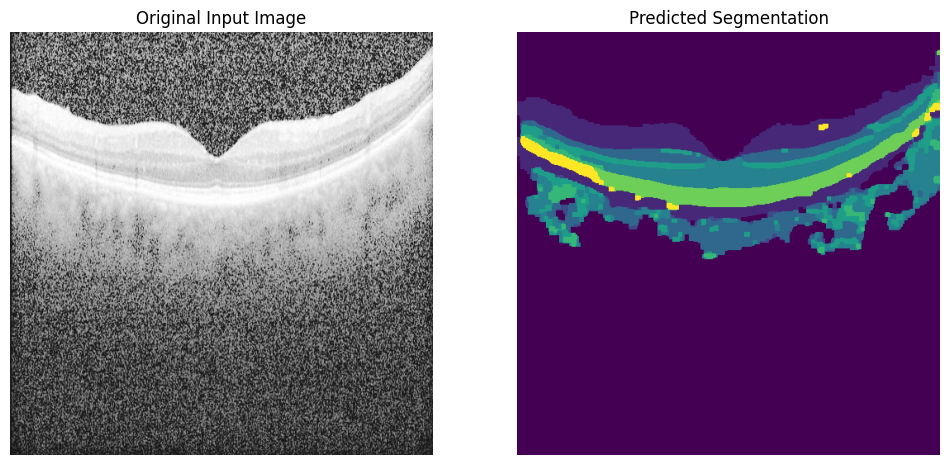

In [17]:
import matplotlib.pyplot as plt
import os
import cv2
import torch
import numpy as np


def clean_mask(predicted_mask, kernel_size=5):
    """Cleans up a predicted mask using morphological operations."""
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Removes small, isolated noise pixels (like the speckles)
    opened_mask = cv2.morphologyEx(predicted_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # Fills in small holes within the main segmented areas
    cleaned_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel)

    return cleaned_mask

def predict_on_single_image(model, image_path, transform, device, save_path=None):
    """
    Loads an image, runs prediction, visualizes the result, and optionally saves it.
    """
    model.eval()

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # Apply the SAME transformations as the validation set for consistency
    if transform:
        augmented = transform(image=image)
        image_tensor = augmented['image'].to(device)

    # Add the batch dimension (1, C, H, W) for the model
    input_tensor = image_tensor.unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        cleaned_prediction=clean_mask(predicted_mask)

    # --- Visualization ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title("Original Input Image")
    ax[0].axis('off')

    ax[1].imshow(cleaned_prediction, cmap='viridis')
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis('off')

    # --- Save the figure to a file ---
    if save_path:
        # Use bbox_inches='tight' to remove extra white space
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Prediction saved to: {save_path}")

    # --- Display the figure in the notebook ---
    plt.show()

# --- Load the saved model ---
MODEL_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation_last_fold.pth")
prediction_model = UNet(in_channels=1, out_channels=NUM_CLASSES)
prediction_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
prediction_model.to(DEVICE)
print("Model loaded and ready for prediction.")

# --- Define paths and run prediction ---
test_image_path = '/content/drive/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/NORMAL-525862-8_jpeg.rf.0ff4d4121217c185c81fd91c7456953d.jpg'

# --- Create a path to save the output image ---
# This will create a 'predictions' folder in your main project directory
output_dir = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'predictions/')
os.makedirs(output_dir, exist_ok=True) # Ensure the folder exists

# Create a new filename for the output
base_name = os.path.basename(test_image_path)
file_name_without_ext = os.path.splitext(base_name)[0]
output_save_path = os.path.join(output_dir, f"{file_name_without_ext}_prediction.png")

# --- Run the function ---
predict_on_single_image(
    model=prediction_model,
    image_path=test_image_path,
    transform=val_transform,
    device=DEVICE,
    save_path=output_save_path
)